## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from utils import reduce_mem_usage

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, roc_auc_score, auc, make_scorer

import xgboost as xgb
from xgboost import XGBClassifier

SEED = 666

# Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# magic word for producing visualizations in notebook
%matplotlib inline

# and setting the size of all plots.
plt.rcParams['figure.figsize'] = [11, 7]

Using TensorFlow backend.


## Load Dataset

In [2]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census = pd.read_csv('data/census-income.data', header=None, sep=',\s', na_values=['?', 'Do not know', 'Not identifiable'], engine='python')

In [3]:
census_columns = [
    'age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital status',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'fill inc questionnaire for veteran\'s admin',
    'veterans benefits',
    'weeks worked in year',
    'year',
    'income class'
]

features_to_drop = [
    'instance weight', # Ignored
    # more than 70% values missing
    'enroll in edu inst last wk',
    'member of a labor union',
    'reason for unemployment',
    'region of previous residence',
    'state of previous residence',
    'migration prev res in sunbelt',
    'family members under 18',
    "fill inc questionnaire for veteran's admin",
    # more than 50% values missing
    'class of worker',
    'major industry code',
    'major occupation code',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    # Vlad Manolache
    "year", # good call Vlad Manolache
    'capital gains',
    'capital losses'
]

categorical_features = [
    #'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'marital status',
    #'major industry code',
    #'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'full or part time employment stat',
    'tax filer stat',
    'detailed household and family stat',
    'detailed household summary in household',
    #'migration code-change in msa',
    #'migration code-change in reg',
    #'migration code-move within reg',
    #'live in this house 1 year ago',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'veterans benefits',
    #'year'
]

numerical_features = [
    'age',
    'wage per hour',
    #'capital gains',
    #'capital losses',  
    'capital gains loss', #Vlad Manolache
    'dividends from stocks',
    'num persons worked for employer',
    'weeks worked in year'
]

census.columns = census_columns
census.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital status                              199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

 ## Clean Dataset

In [5]:
class DefaultZero(dict):
    def __missing__(self, key):
        return 0

def clean_dataset(df):
    # replace field that contains Not in Universe with NaN
    df = df.replace(r'Not in universe\w*?', np.nan, regex=True)
    
    # Fill NaN
    df['hispanic origin'] = df['hispanic origin'].fillna(df['hispanic origin'].mode()[0])
    df['country of birth father'] = df['country of birth father'].fillna(df['country of birth father'].mode()[0])
    df['country of birth mother'] = df['country of birth mother'].fillna(df['country of birth mother'].mode()[0])
    df['country of birth self'] = df['country of birth self'].fillna(df['country of birth self'].mode()[0])
    
    # Feature Engineering
    df['sex'] = df['sex'].map({'Female': 0, 'Male': 1})
    
    # From Vlad Manolache
    # -------------------------

    # Collapse marrital status
    marrital_status_single = ['Never married', 'Separated', 'Divorced', 'Widowed']
    marrital_status_married = ['Married-civilian spouse present', 'Married-spouse absent', 'Married-A F spouse present']
    df['marital status'] = df['marital status'].replace(marrital_status_single, 0)
    df['marital status'] = df['marital status'].replace(marrital_status_married, 1)
    
    # Inspired by the winners
    map_education = {
        'Doctorate degree(PhD EdD)': 3,
        'Prof school degree (MD DDS DVM LLB JD)': 3,
        'Masters degree(MA MS MEng MEd MSW MBA)': 3,
        'Bachelors degree(BA AB BS)': 2,
        'Associates degree-academic program': 2,
        'Associates degree-occup /vocational': 2,
        'Some college but no degree': 1,
        '12th grade no diploma': 1,
        '11th grade': 1,
        '10th grade': 1,
        '9th grade': 1,
        'High school graduate': 1,
        '7th and 8th grade': 0,
        '5th or 6th grade': 0,
        '1st 2nd 3rd or 4th grade': 0,
        'Less than 1st grade': 0,
        'Children': 0
    }
    
    df['education'] = df['education'].map(map_education)
    
    # From Vlad Manolache
    df['capital gains loss'] = df['capital gains'] - df['capital losses']
    
    # From Jan Jakob Lameijer
    map_race = {
        'White': 1,
        'Black': 0,
        'Asian or Pacific Islander': 0,
        'Other': 0,
        'Amer Indian Aleut or Eskimo': 0
    }

    df['race'] = df['race'].map(map_race)

    map_hisp = {
        'All other': 0,
        'Mexican (Mexicano)': 1,
        'Mexican-American': 1,
        'Puerto Rican': 1,
        'Central or South American': 1,
        'Other Spanish': 1,
        'Chicano': 1,
        'Cuban': 1
    }
    df['hispanic origin'] = df['hispanic origin'].map(map_hisp)

    map_birth = DefaultZero({'United-States': 1})
    df['country of birth self'] = df['country of birth self'].map(map_birth)
    df['country of birth father'] = df['country of birth father'].map(map_birth)
    df['country of birth mother'] = df['country of birth mother'].map(map_birth)
    
    # From Andrei Ratushin
    
    #First - I shall collect grandchilds 18+, as their numbers are non-representative (<1%) in current segmentation
    df.loc[df['detailed household and family stat'].str.contains('Grandchild'),'detailed household and family stat']='Child 18+'
    df.loc[df['detailed household and family stat'].str.contains('Child'),'detailed household summary in household']='Child 18+'
    df.loc[df['detailed household and family stat'].str.contains('Child'),'detailed household and family stat']='Child 18+'
    
    # Drop features
    df = df.drop(features_to_drop, axis=1)
    
    # Encode income class column
    df['income class'] = df['income class'].map({'- 50000.': 0, '50000+.': 1})
    
    # Reduce memory usage
    df, _ = reduce_mem_usage(df)

    return df

In [6]:
census = clean_dataset(census)
census.head()

Memory usage of dataframe:  36.53387451171875  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 12.558599472045898 MB
This is 34.38% of the initial size


,age,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,race,hispanic origin,sex,full or part time employment stat,...,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,veterans benefits,weeks worked in year,income class,capital gains loss
0,73,0,0,1,0,0,1,0,0,Not in labor force,...,0,1,1,1,Native- Born in the United States,0,2,0,0,0
1,58,4,34,1,0,0,1,0,1,Children or Armed Forces,...,1,1,1,1,Native- Born in the United States,0,2,52,0,0
2,18,0,0,1,0,0,0,0,0,Not in labor force,...,0,0,0,0,Foreign born- Not a citizen of U S,0,2,0,0,0
3,9,0,0,0,0,0,1,0,0,Children or Armed Forces,...,0,1,1,1,Native- Born in the United States,0,0,0,0,0
4,10,0,0,0,0,0,1,0,0,Children or Armed Forces,...,0,1,1,1,Native- Born in the United States,0,0,0,0,0


In [7]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 24 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      199523 non-null  uint8 
 1   detailed industry recode                 199523 non-null  uint8 
 2   detailed occupation recode               199523 non-null  uint8 
 3   education                                199523 non-null  uint8 
 4   wage per hour                            199523 non-null  uint16
 5   marital status                           199523 non-null  uint8 
 6   race                                     199523 non-null  uint8 
 7   hispanic origin                          199523 non-null  uint8 
 8   sex                                      199523 non-null  uint8 
 9   full or part time employment stat        199523 non-null  object
 10  dividends from stocks                    199

## Split train and validation sets

In [8]:
X = census.drop('income class', axis=1)
y = census['income class']

In [9]:
y.mean()

0.06205800834991455

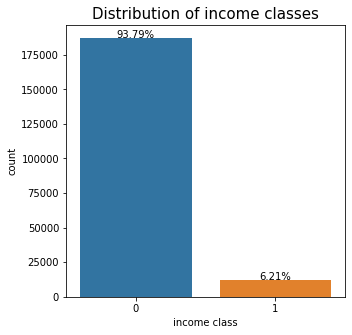

In [10]:
plt.figure(figsize=(5, 5))
total = census.shape[0]
ax = sns.countplot(x="income class", data=census)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),
            ha="center")
plt.title('Distribution of income classes', fontsize=15)
plt.show()

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [12]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
ratio

15.113264688067838

## Bayesian Hyperparameter Tuning with Hyperopt

In [13]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore'))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest(k=75))
])

In [14]:
X_train = pipeline.fit_transform(X_train, y_train)
X_val = pipeline.transform(X_val)

In [15]:
#scorer = make_scorer(roc_auc_score)

In [16]:
# Scoring and optimization functions
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val.values)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    
    predictions = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)
    
    fpr, tpr, thresholds = roc_curve(y_val, predictions)
    score = auc(fpr, tpr)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

In [17]:
def optimize(random_state=SEED):
    """
    This is the optimization function that given a space of hyperparameters and a scoring function, 
    finds the best hyperparameters.
    """
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 2000, 100),
        'eta': hp.quniform('eta', 0.025, 0.1, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'scale_pos_weight': ratio,
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 5,
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, max_evals=250, rstate=np.random.RandomState(random_state))
    return best

In [ ]:
best_hyperparams = optimize()
best_hyperparams

In [20]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore'))
    ]), categorical_features),
    remainder='drop'
)

selectKBest_model = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest(k=75)),
    ('clf', XGBClassifier(
        learning_rate=0.075,
        n_estimators=1800,
        max_depth=2,
        min_child_weight=6,
        gamma=0.95,    
        subsample=0.95,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,
        random_state=666, 
        tree_method='gpu_hist',
        objective='binary:logistic'))
])

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
selectKBest_model.fit(X_train, y_train);
y_pred = selectKBest_model.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     37429
           1       0.31      0.89      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.8788036744291863


## Test

### Load Dataset

In [22]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census_test = pd.read_csv('data/census-income.test', header=None, sep=',\s',  na_values=['?', 'Do not know', 'Not identifiable'], engine='python')

In [23]:
census_test.columns = census_columns
census_test.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


### Clean Dataset

In [24]:
census_test = clean_dataset(census_test)
census_test.head()

Memory usage of dataframe:  18.26708984375  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 6.279392242431641 MB
This is 34.38% of the initial size


,age,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,race,hispanic origin,sex,full or part time employment stat,...,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,veterans benefits,weeks worked in year,income class,capital gains loss
0,38,6,36,0,0,1,1,1,0,Full-time schedules,...,4,0,0,0,Foreign born- Not a citizen of U S,0,2,12,0,0
1,44,37,12,2,0,1,1,0,0,PT for econ reasons usually PT,...,1,1,1,1,Native- Born in the United States,0,2,26,0,0
2,2,0,0,0,0,0,1,1,1,Children or Armed Forces,...,0,1,1,1,Native- Born in the United States,0,0,0,0,0
3,35,29,3,1,0,0,1,0,0,Children or Armed Forces,...,5,1,1,1,Native- Born in the United States,2,2,52,0,0
4,49,4,34,1,0,0,1,0,1,Full-time schedules,...,4,1,1,1,Native- Born in the United States,0,2,50,0,0


In [25]:
census_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   age                                      99762 non-null  uint8 
 1   detailed industry recode                 99762 non-null  uint8 
 2   detailed occupation recode               99762 non-null  uint8 
 3   education                                99762 non-null  uint8 
 4   wage per hour                            99762 non-null  uint16
 5   marital status                           99762 non-null  uint8 
 6   race                                     99762 non-null  uint8 
 7   hispanic origin                          99762 non-null  uint8 
 8   sex                                      99762 non-null  uint8 
 9   full or part time employment stat        99762 non-null  object
 10  dividends from stocks                    99762 non-null  u

### Predictions

In [26]:
X_test = census_test.drop('income class', axis=1)
y_test = census_test['income class']

#### SelectKBest

In [27]:
y_pred_test = selectKBest_model.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93576
           1       0.31      0.89      0.46      6186

    accuracy                           0.87     99762
   macro avg       0.65      0.88      0.69     99762
weighted avg       0.95      0.87      0.90     99762

AUC: 0.8793472602382482


In [ ]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/XGBoost HyperOpt with SelectKBest.csv', index=False)